In [1]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from persim import PersImage
import gudhi
import os
import glob
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
import time
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn import preprocessing

In [894]:
flist=np.sort(glob.glob("*3d_Z2_Ising*/0.5/*.txt"))

In [ ]:
for f in flist[50:100]:
    t0 = time.time()
    data = np.loadtxt(f, dtype=int)
    alpha_complex=gudhi.AlphaComplex(data)
    simplex_tree=alpha_complex.create_simplex_tree()
    PD=simplex_tree.persistence()
    PD0=[]
    PD1=[]
    PD2=[]
    for elm in PD:
        if elm[0]==1:
            PD1.append((elm[1][0],elm[1][1]-elm[1][0]))
        elif elm[0]==2:
            PD2.append((elm[1][0],elm[1][1]-elm[1][0]))
        else:
            if elm[1][1]!=float('inf'):
                PD0.append((elm[1][0],elm[1][1]-elm[1][0]))
    PD0=np.round(PD0,decimals=5)
    PD1=np.round(PD1,decimals=5)
    PD2=np.round(PD2,decimals=5)
    loc,counts=np.unique(PD0,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD0.dat",toSave)
    loc,counts=np.unique(PD1,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD1.dat",toSave)
    loc,counts=np.unique(PD2,axis=0,return_counts=True)
    toSave=np.array([[loc[i][0],loc[i][1],counts[i]] for i in np.arange(len(counts))])
    np.savetxt(f[:len(f)-4]+"PD2.dat",toSave)
    print(f, time.time() - t0)

Data_3d_Z2_Ising_Met_N=15_K=200\0.5\1553281529.txt 12.3858482837677
Data_3d_Z2_Ising_Met_N=15_K=200\0.5\1553281544.txt 12.510938167572021


In [ ]:
fPD1list=np.sort(glob.glob("*3d_Z2_Ising*/*/*PD1.dat"))
TPD1list=[]
for f in fPD1list:
    TPD1list.append(float(f[32:35]))
np.array(np.unique(TPD1list, return_counts=True)).T

In [847]:
#pdlocnum has format [[birth1, persistence1, counts1],...]
#bounds should be a list [bmin,bmax,pmin,pmax]
#bins should be a list [bbins, pbins]
def PerIm(pdloc,bounds,bins,stdev,res=1000):
    x = np.linspace(bounds[0], bounds[1], res)
    y = np.linspace(bounds[2], bounds[3], res)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z=np.zeros([res,res])
    for i in np.arange(len(pdloc)):
        z=z+pdloc[i][1]*pdloc[i][2]*np.exp((-0.5*(xx-pdloc[i][0])**2-0.5*(yy-pdloc[i][1])**2)*stdev**-2)
    return z.reshape(bins[0],res//bins[0],bins[1],res//bins[1]).sum(3).sum(1)

In [848]:
fPD0list=np.sort(glob.glob("*3d_Z2_Ising*/*/*PD0.dat"))
TPD0list=[]
for f in fPD0list:
    TPD0list.append(float(f[32:35]))

fPD1list=np.sort(glob.glob("*3d_Z2_Ising*/*/*PD1.dat"))
TPD1list=[]
for f in fPD1list:
    TPD1list.append(float(f[32:35]))

fPD2list=np.sort(glob.glob("*3d_Z2_Ising*/*/*PD2.dat"))
TPD2list=[]
for f in fPD2list:
    TPD2list.append(float(f[32:35]))

In [849]:
pds0=[np.loadtxt(f) for f in fPD0list]
pds1=[np.loadtxt(f) for f in fPD1list]
pds2=[np.loadtxt(f) for f in fPD2list]

In [865]:
bounds=[0,5,0,5]
bins=[10,10]
res=bins[0]*10

imgs1=[PerIm(pd,bounds,bins,1,res=res) for pd in pds1]
imgs2=[PerIm(pd,bounds,bins,1,res=res) for pd in pds2]

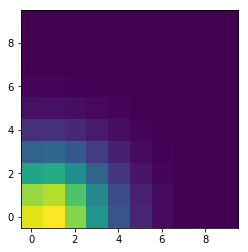

In [866]:
plt.imshow(imgs2[0],origin='lower')

In [867]:
imgs1_array=np.array([img.flatten() for img in imgs1])
imgs2_array=np.array([img.flatten() for img in imgs2])
imgs12_array=np.array([np.array([imgs1_array[i],imgs2_array[i]]).flatten() for i in range(len(imgs1_array))])

In [885]:
labels1=[int(t<2.0166) for t in TPD1list]
labels2=[int(t<2.01) for t in TPD2list]

In [886]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(imgs12_array, labels2, TPD2list, test_size=0.5)

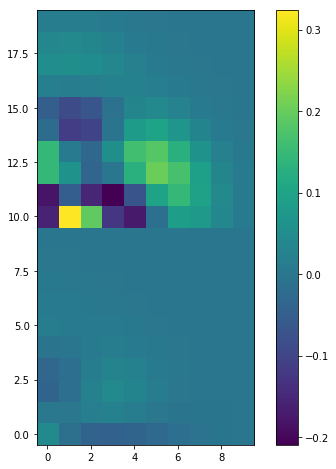

In [887]:
logreg = LogisticRegression(C=0.1, solver='liblinear', penalty='l2')
logreg.fit(X_train, y_train)

inverse_image = np.copy(logreg.coef_).reshape((20,10))
fig, ax = plt.subplots(figsize=(8,8))
cs = ax.imshow(inverse_image, origin='lower')
cbar = fig.colorbar(cs)

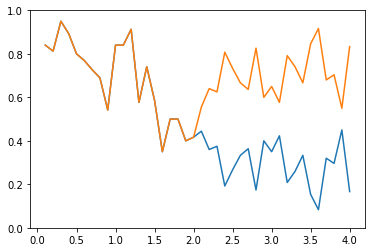

In [890]:
pred = logreg.predict(X_test)
diff = abs(pred-y_test)
TT = np.arange(0.1,4.05,0.1)
TT = np.round(TT, decimals=3)
avg = np.zeros(len(TT))
acc = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])
    acc[i] = np.mean(1-diff[np.where(T_test==TT[i])[0]])

plt.ylim((0,1))
plt.plot(TT, avg)
plt.plot(TT, acc)

2.531062124248497


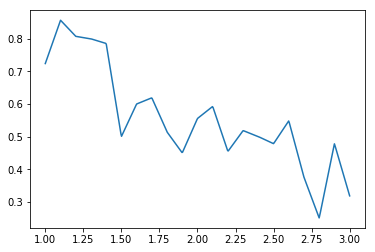

In [875]:
tRange = np.linspace(1.0,3.0,500)
interps = np.interp(tRange, TT, avg)

Tc = tRange[abs(interps-0.5).argmin()]

print(Tc)
plt.plot(tRange, interps)

**PCA**

In [839]:
pca = PCA(n_components=2)
X_r = pca.fit(imgs12_array).transform(imgs12_array)

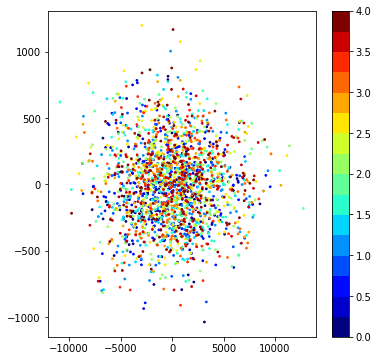

In [840]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,4,17)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter([elm[0] for elm in X_r],[elm[1] for elm in X_r],c=TPD2list,s=3,cmap=cmap, norm=norm)
cbar = fig.colorbar(scat)
plt.show()

In [841]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(imgs12_array, labels2, TPD2list, test_size=0.5)

In [842]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

1.9841683366733467


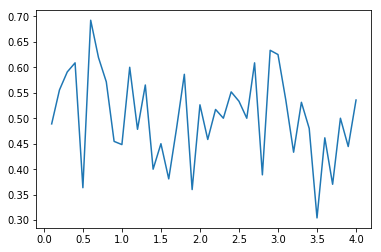

In [843]:
pred = kmeans.predict(X_test)
diff = abs(pred - y_test)
TT = np.unique(T_test)
TT = np.round(TT, decimals=3)
avg = np.zeros(len(TT))
acc = np.zeros(len(TT))
for i in np.arange(len(TT)):
    avg[i] = np.mean(pred[np.where(T_test==TT[i])[0]])
    acc[i] = np.mean(1-diff[np.where(T_test==TT[i])[0]])

plt.plot(TT, avg)

tRange = np.linspace(1.6,2.5,500)
interp = np.interp(tRange, TT, avg)

Tc = tRange[abs(interp-0.5).argmin()]
print(Tc)